# Adaptive Rejection Sampling
Dhilan Patel, Vara Qi Gunananthan​ \
May 9, 2025

## Introduction
Adaptive rejection sampling is a technique developed for univariate log-concave probability density functions $f(x)$. Immediate applications are to concave functions with non-negative domains, such as variations of the gamma and logistic distributions. It serves as an improvement on traditional rejection sampling by using an envelope and squeezing function that converges to the true density, even if the explicit computation of $f(x)$ is expensive. The bounding and squeezing functions are not determined in advance, and instead are dynamically tuned over the algorithm's iterations. This technique is most suitable for the simulation of systems with properties such as density-mode that are difficult to calculate. In this report, we will derive and prove convergence for adaptive rejection sampling, and provide comparisons on example data sets to traditional rejection sampling and Gibbs sampling.

## Motivations
In non-conjugate models, where the posterior distribution at an update is not in the same parametric family as the prior, Gibbs sampling can be very expensive, since many different densities will have to be sampled from. Traditional rejection sampling will also be very inefficient as it involves a large number of optimizations, each requiring multiple calculations of the unnormalized target distribution $g(x) = cf(x)$. The key advantage of adaptive rejection sampling is reducing the number of times we have to evaluate $g(x)$, which is achieved in two ways:
1.  Assuming $f(x)$ is log-concave eliminates the need to find $\sup_{x \in D}\{g(x)\}$.
2. Reducing the probability of needing to evaluate $g(x)$ after each rejection by using the new information about $g$ to update the envelope and squeezing functions.

## Assumptions
The following assumptions are required for adaptive rejection sampling to build a piecewise-linear tangent envelope $U_k(x)$ of $h(x) = \ln g(x)$.
1. Domain $D$ is connected.
2. $g(x)$ is continuous and differentiable everywhere in $D$
3. $h(x)$ is concave everywhere in $D$ (i.e. $h'(x)$ decreases monotonically).

## Definitions
Suppose $h(x)$ and $h'(x)$ have been calculated $\forall x \in T_k = \{x_1 \leq \dots \leq x_k\}$ &sub; $D$. We define the rejection envelope on $T_k$ as $\exp u_k$ where $u_k$ is a piecewise-linear upper hull formed from the tangents to $h(x)$ at $T_k$.

Tangents at $x_j$ and $x_{j+1}$ intersect at
$$
z_j = \frac
{h(x_{j+1}) - h(x_j) - x_{j+1}h'(x_{j+1}) + x_{j}h'(x_j)}
{h'(x_j) - h'(x_{j+1})}
$$

We then define the linear envelop piece $\forall \text{ } x \in [z_{j-1}, z_j] \text{ } \forall j = 1, \dots , k$
$$
u_k(x) = h(x_j) + (x - x_j)h'(x_j)
$$
where $z_0$ and $z_k$ are the lower and upper bounds of $D$ if bounded, or $\pm \infty$ if unbounded, respectively. This is important to ensure that all terms converge when we exponentiate and integrate when normalizing the envelopes. In other words, if we have an infinite domain, we need our log-envelopes to have end-behavior approaching $-\infty$, but this is not a problem if our domain is finite-bounded. 

We then convert our unnormalized log-envelope to our "true" envelope of $f(x)$ with
$$
s_k(X) = \exp U_k(X)/ \int_{D} \exp u_k(x')dx'
$$

Lastly, we define squeezing function on $T_k$ as $\exp l(x)$ $\forall \text{ } x \in [z_{j}, z_{j+1}] \text{ } \forall j = 1, \dots , k$
$$
l_k(x) = \frac
{(x_{j+1} - x) h(x_j) + (x - x_j) h(x_{j+1})}
{x_{j+1} - x_j}
$$

Because $h(x)$ is concave, $l_k(x) \leq h(x) \leq u_k(x)$.


| Notation | Definition |
|---|---|
| $f(x)$ | Target distribution |
| $g(x)$ | Unnormalized target distribution |
| $h(x)$ | $\ln g(x)$|
| $u_k(x)$ | Upper hull formed from tangents to $h(x)$, formed from $k$ points|
| $g_u(x)$ | Envelope function = $\exp(u_k(x))$|
| $l_k(x)$ | Lower hull formed from chords to $h(x)$, formed from $k$ points|
| $g_l(x)$ | Squeezing function = $exp(l_k(x))$|
| $s_k(x)$ | Normalized envelope function|

## Algorithm
### Initialization

*  Initialize $k$ abscissae $x_1, \dots , x_k \in T_k$
*  Ensure the upper hull above zero is bounded
  * If D is unbounded on the left, choose $x_1$ such that $h'(x_1) > 0$
  * If D is unbounded on the right, choose $x_k$ such that $h'(x_k) < 0$
    * This makes sure that each side of the upper hull either meets the boundary or crosses the x-axis, so the integral of the envelope function can converge
  * The lower hull is vertical at $x_1$ and $x_k$, so the integral of the squeezing function converges
* Calculate the functions $u_k(x)$, $s_k(x)$ and $l_k(x)$ from the $k$ starting points


### Sampling Step

* Sample a value $x^{*}$ from $s_k(x)$, the normalized envelope function
* Perform a squeezing test
  * If $w \le \exp(l_k(x^{*}) - u_k(x^{*}))$, accept $x^{*}$, where $w$ ~ Uniform(0,1)
  * This is essentially sampling uniformly in the range $(0, \exp(u_k(x^{*})))$ as we would do in traditional rejection sampling, but using the acceptance criteria of $\exp(l_k(x^{*}))$ instead of $\exp(h(x)) = g(x)$. Since $l_k(x) \leq h(x)$, we are able to perform an initial check without evaluating $g(x)$ at a high probability for acceptance. Only in the rare event that we fail to accept $x^{*}$ here do we perform the typical rejection sampling as learned in class. Intuitively, we accept $x^*$ with increasing probability as the upper and lower envelopes converge to $g(x)$ , so the algorithm actually gets more efficient as it runs.
* If not accepted, perform a rejection test
  * If $w \le \exp(h(x^{*}) - u_k(x^{*}))$, accept $x^{*}$, reusing the same $w$ as in the previous step
  * Despite not being able to accept the sample in the squeezing test, $w$ may still lie under $h(x^{*})$ but above $l_k(x^{*})$. We revert to traditional rejection sampling and evaluate the true $\exp(h(x^{*})) = g(x^{*})$ for the acceptance probability.
  * Otherwise reject $x^{*}$
  * This is when explicit evaluations of $h(x^{*})$ and $h'(x^{*})$ are required, so as the squeezing and envelope functions get closer, the probability of having to evaluate the target distribution decreases.

### Updating Step
* If evaluations of $h(x^*)$ and $h'(x^*)$ are carried out, add $x^*$ to $T_k$ to form $T_{k+1}$
* Relabel $T_{k+1}$ in ascending order
* Update $u_k(x)$, $s_k(x)$ and $l_k(x)$ to $u_{k+1}(x)$, $s_{k+1}(x)$ and $l_{k+1}(x)$ based on the points in $T_{k+1}$, and increment $k$
* This step takes advantage of the new information gained by evaluating $\exp(h(x^{*})) = g(x^{*})$ to increase the number of segments in our piecewise-linear envelopes, allowing them to converge to $h(x)$ and improving the efficiency of this algorithm.
* Return to sampling step if $n$ points have not already been accepted

Intuitively, each evaluation of $h(x)$ results in envelope and squeezing functions that approximate $h(x)$ more closely, reducing the probability of needing to evaluate $h(x)$ in the next step.


## Proof
Let $x^{*}_{r}$ denote the $r$th sampled value of $x$, regardless of its acceptance or inclusion in $T_k$. Define
$$
\delta =
\begin{cases}
0, & \text{if } x^*_r \text{ was accepted at the squeezing test},\\
1, & \text{if } x^*_r \text{ was accepted at the rejection test},\\
2, & \text{if } x^*_r \text{ was rejected}.
\end{cases}
$$
Let $H_r$ denote the history of the process up to and including $x^*_r$ such that it defines the current upper and lower hulls:
$$
H_r = \{(x^*_i, \delta) : i = 1, \dots , r\}
$$
Therefore,
$$
[(x^{*}_{r+1} = x) \cap (\delta_{r+1} \neq 2) \text{ } | \text{ } H_r] = \frac{\exp h(x)}{\int_{D} \exp u_k(x')dx'}
$$
and finally
$$
[(x^{*}_{r+1} = x) \cap (\delta_{r+1} \neq 2)] = \frac{\exp h(x)}{\int_{D} \exp h(x')dx'} = f(x)
$$
which does not dependent on $H_r$. In other words, accepted values of $x$ are drawn independently from $f(x)$

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import bisect
from typing import List
import scipy.special as special

"""
Original code from rejection sampling homework
"""

class RNG:
    def __init__(self, seed=None):
        self._rng = np.random.default_rng(seed)
        self.random = self._rng.random
    
    def seed(self, seed=None):
        self._rng = np.random.default_rng(seed)
    
    def uniform(self, low=0.0, high=1.0, size=None):
        return low + (high - low) * self.random(size)
    
    # choose a random object from a list
    def choice(self, list_, size=None):
        u = self.random(size)
        return list_[np.floor(u * len(list_)).astype(int)]
    
    def discrete(self, weights, list_=None, size=None):
        total_weight = sum(weights)
        intervals = np.cumsum(weights) / total_weight
        u_samples = self.random(size)
        return [list_[bisect.bisect_left(intervals, s)] for s in u_samples]
    
    def bernoulli(self, p=0.5, size=None):
        assert 0 <= p <= 1, "p must be between 0 and 1"
        u = self.random(size)
        return (u < p).astype(int)
        
    def binomial(self, n=1, p=0.5, size=None):
        assert 0 <= p <= 1, "p must be between 0 and 1"
        sample = lambda x, y: np.sum(self.bernoulli(x, y))
        return np.array([sample(p, n) for _ in range(size)])
    
    def exponential(self, lambda_=1.0, size=None):
        assert lambda_ > 0, "lambda must be positive"
        return -1/lambda_ * np.log(1 - self.uniform(size=size))
    
    def normal(self, mean=0.0, std=1.0, size=None):
        R = np.sqrt(-2 * np.log(1 - self.uniform(size=size)))
        Theta = 2 * np.pi * self.uniform(size=size)
        return mean + std * R * np.cos(Theta)
        
    def poisson(self, lambda_=1.0, size=None):
        assert lambda_ > 0, "lambda must be positive"
        samples = np.zeros(size)
        for i in range(size):
            N, sum = 0, 0
            while True:
                X = self.exponential(lambda_, size=1)
                sum += X
                if sum > 1:
                    break
                N += 1
            samples[i] = N
        return samples

    def beta(self, a=1.0, b=1.0, size=None):
        assert a > 0 and b > 0, "a and b must be positive"
        assert isinstance(a, int) and isinstance(b, int), "a and b must be integers for this specific implementation"
        k, n = a, b + a - 1
        samples = np.array([self.uniform(size=n) for _ in range(size)])
        samples.sort(axis=1)
        return np.array([row[k-1] for row in samples])


    def triangular(self, low=0.0, high=1.0, mode=None, size=None):
        assert low <= mode <= high, "low <= mode <= high"
        samples = self.uniform(size=size)
        samples.sort()
        crit = (mode - low) / (high - low)
        return np.where(
            samples < crit, 
            low + np.sqrt(samples * (high - low) * (mode - low)), 
            high - np.sqrt((1 - samples) * (high - low) * (high - mode))
            )

    def weibull(self, shape=1.0, scale=1.0, size=None):
        assert shape > 0, "shape must be positive"
        assert scale > 0, "scale must be positive"
        return scale * (-np.log(1 - self.uniform(size=size)))**(1/shape)

class RandomVariable():
    def __init__(self, rng):
        self.rng = rng
        
    def pdf(self, x):
        raise NotImplementedError
    
    def rsv(self, size=None):
        raise NotImplementedError

class Uniform(RandomVariable):
    def __init__(self, rng, low=0.0, high=1.0):
        super().__init__(rng)
        self.low = low
        self.high = high
        
    def rsv(self, size=None):
        return np.array(self.rng.uniform(low=self.low, high=self.high, size=size))

    def pdf(self, x):
        return np.array(np.where((x >= self.low) & (x <= self.high), 1 / (self.high - self.low), 0))

class Discrete(RandomVariable):
    def __init__(self, rng, weights, list_=None):
        super().__init__(rng)
        self.weights = weights
        self.list_ = list_
        
    def rsv(self, size=None):
        return np.array(self.rng.discrete(weights=self.weights, list_=self.list_, size=size))

    def pdf(self, x):
        return np.array(self.weights[self.list_.index(x)])

class Mixture(RandomVariable):
    def __init__(self, rng, weights, components: List[RandomVariable]):
        assert len(weights) == len(components), "weights and components must have the same length"
        super().__init__(rng)
        self.weights = weights
        self.components = components
    
    def rsv(self, size=None):
        sampled_components = Discrete(self.rng, self.weights, self.components).rsv(size=size)
        return np.array([comp.rsv() for comp in sampled_components])

    def pdf(self, x):
        return np.array(sum([w * c.pdf(x) for w, c in zip(self.weights, self.components)]))

class Normal(RandomVariable):
    def __init__(self, rng, mean=0.0, std=1.0):
        super().__init__(rng)
        self.mean = mean
        self.std = std
        
    def rsv(self, size=None):
        return np.array(self.rng.normal(mean=self.mean, std=self.std, size=size))

    def pdf(self, x):
        return np.array(np.exp(-0.5 * ((x - self.mean) / self.std)**2) / np.sqrt(2 * np.pi * self.std**2))

def rejection_rsv(target_pdf, proposal_rv: RandomVariable, majorizing_constant, size, rng=None):
    if rng is None:
        rng = RNG()
    accept = []
    trials = 0
    U = Uniform(rng, 0, 1)
    while len(accept) < size:
        x = proposal_rv.rsv(1)
        u = U.rsv(None)
        if u <= target_pdf(x) / (majorizing_constant * proposal_rv.pdf(x)):
            accept.append(x)
        trials += 1
    efficiency = size / trials
    return np.array(accept), efficiency

In [139]:
import numpy as np
import bisect

# -----------------------------------------------------------------------------
# RNG Helper (Initialization Step)
# Corresponds to paper’s initialization of the random number generator
# -----------------------------------------------------------------------------
class ARNG:
    def __init__(self, seed=None):
        self._rng = np.random.default_rng(seed)
    def uniform(self, low=0.0, high=1.0, size=None):
        return self._rng.random(size) * (high - low) + low
    def choice(self, a, p=None):
        return self._rng.choice(a, p=p)


def adaptive_rejection_sampling(
    log_pdf,
    dlog_pdf,
    Dl,
    Du,
    initial_x,
    n_samples,
    rng=None
):
    """
    Adaptive Rejection Sampling for a log‑concave target.

    References to paper’s steps:
      - Initialization: sort initial abscissae T_k, cache h(x) and h'(x)
      - Sampling: build hull, sample segment and x*, perform tests
      - Update: insert rejected x* into T_k and refine the envelope
    """

    # -------------------------------------------------------------------------
    # Initialization: prepare RNG and abscissae set T_k
    # (Paper Sec. 2.2 “initialization”)
    # -------------------------------------------------------------------------
    if rng is None:
        rng = ARNG()

    Tk = sorted(initial_x)         # initial abscissae
    samples = []                   # accepted draws
    trials = 0                     # total proposals
    cached_vals = {}               # cache for h(x)
    cached_dvals = {}              # cache for h'(x)
    num_calculations = [0]         # count of log‑pdf evaluations
    calculations_array = [0]       # history of evaluations
    efficiency_array = []          # history of accepted / total samples


    def calculate_trueval(x):
        """Cache h(x)=log_pdf(x) and h'(x)=dlog_pdf(x)."""
        cached_vals[x] = log_pdf(x)
        cached_dvals[x] = dlog_pdf(x)
        num_calculations[0] += 1
        return cached_vals[x]


    # -------------------------------------------------------------------------
    # Build/Update Hull Function
    # (Paper Sec. 2.2 “build hat”)
    # -------------------------------------------------------------------------
    def construct_hull(abscissae):
        """
        Given current T_k, compute:
          - slopes m_i, intercepts b_i of tangents
          - intersection points z_i
          - normalized piece probabilities p_i
        """
        m, b = [], []
        for x in abscissae:
            slope = cached_dvals[x]
            intercept = cached_vals[x] - slope * x
            m.append(slope)
            b.append(intercept)

        # intersection points z_0...z_k
        z = [Dl]
        for i in range(len(abscissae) - 1):
            zi = (b[i+1] - b[i]) / (m[i] - m[i+1])
            z.append(zi)
        z.append(Du)

        # compute piece areas A_i = ∫ exp(m_i x + b_i) dx over [z_i, z_{i+1}]
        A = []
        for i in range(len(abscissae)):
            if abs(m[i]) > 1e-16:
                e_low  = np.exp(m[i] * z[i])
                e_high = np.exp(m[i] * z[i+1])
                Ai = np.exp(b[i]) * (e_high - e_low) / m[i]
            else:
                Ai = np.exp(b[i]) * (z[i+1] - z[i])
            A.append(Ai)

        Z = sum(A)
        p = np.array(A) / Z         # normalized envelope weights
        return m, b, z, p


    # -------------------------------------------------------------------------
    # Pre‑compute h(x), h'(x) at initial abscissae
    # -------------------------------------------------------------------------
    for x in Tk:
        calculate_trueval(x)
    calculations_array.append(num_calculations[0])


    # -------------------------------------------------------------------------
    # Main Sampling Loop
    # (Paper Sec. 2.2 “sampling” + “update”)
    # -------------------------------------------------------------------------
    while len(samples) < n_samples:
        # 1) Build the piecewise‑exponential envelope S_k(x)
        m, b, z, p = construct_hull(Tk)

        # 2) Sample a segment index i ~ p
        i = rng.choice(len(p), p=p)

        # 3) Sample x* within [z[i], z[i+1]] via inverse‑CDF
        u = rng.uniform()
        if abs(m[i]) > 1e-16:
            e_low  = np.exp(m[i] * z[i])
            e_high = np.exp(m[i] * z[i+1])
            x_star = (1.0 / m[i]) * np.log(u * (e_high - e_low) + e_low)
        else:
            x_star = z[i] + u * (z[i+1] - z[i])

        # 4) Squeeze test (lower hull) and full rejection test
        w = rng.uniform()
        xL = Tk[i]
        xR = Tk[i+1] if i+1 < len(Tk) else Du
        hL = cached_vals[xL]
        slope_sec = ((cached_vals[xR] - hL) / (xR - xL)) if xR != np.inf else 0.0
        intercept_sec = hL - slope_sec * xL

        hat_val = m[i] * x_star + b[i]
        sec_val = slope_sec * x_star + intercept_sec

        # Accept by squeeze test
        if w <= np.exp(sec_val - hat_val):
            samples.append(x_star)
            calculations_array.append(num_calculations[0])

        else:
            # Evaluate h(x*) if needed
            log_val = cached_vals.get(x_star, calculate_trueval(x_star))
            # Full rejection test
            if w <= np.exp(log_val - hat_val):
                samples.append(x_star)
                calculations_array.append(num_calculations[0])
            else:
                # 5) Update: reject and insert x* into abscissae T_k
                bisect.insort(Tk, x_star)

        trials += 1
        efficiency_array.append(len(samples) / trials)


    # -------------------------------------------------------------------------
    # Finalize output
    # -------------------------------------------------------------------------
    samples = np.array(samples)
    efficiency = n_samples / trials
    return samples, efficiency, efficiency_array, calculations_array

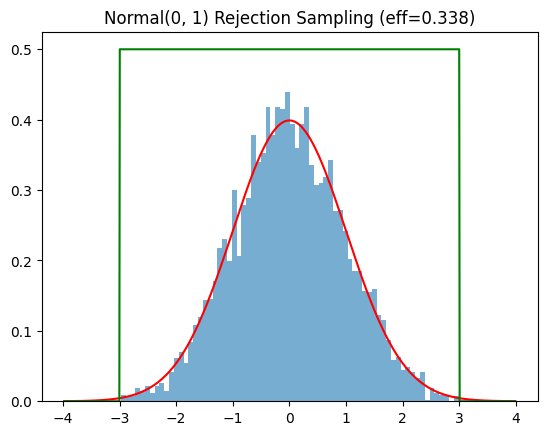

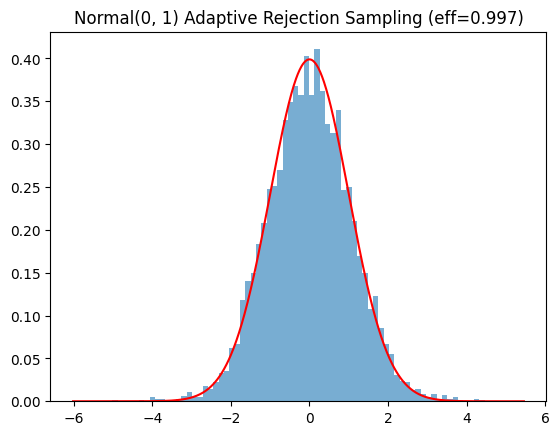

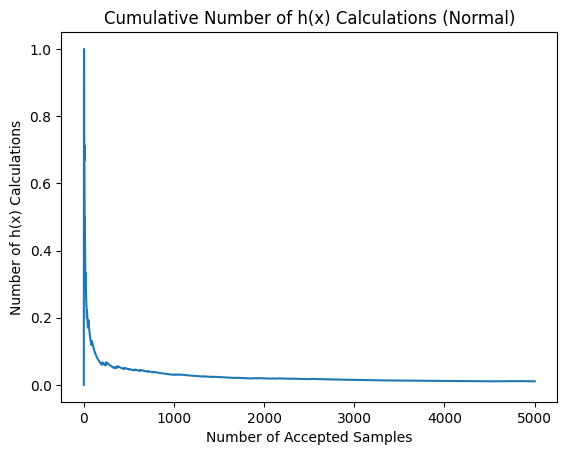

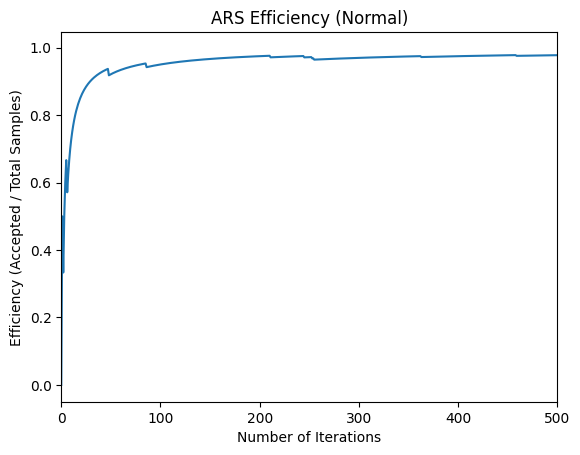

In [ ]:
"""
Comparisons between traditional and adaptive rejection sampling using a standard normal target distribution
"""

N = 5000

# ----- Traditional Rejection Sampling -----
rng = RNG()
target_pdf = Normal(rng, mean=0, std=1).pdf
proposal = Uniform(rng, low=-3, high=3)
M = 3

trad_samples, trad_efficiency = rejection_rsv(target_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title('Normal(0, 1) Rejection Sampling (eff={:.3f})'.format(trad_efficiency))

x = np.linspace(trad_samples.min() - 1, trad_samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.plot(x, M*proposal.pdf(x), "green")
plt.show()

# ----- Adaptive Rejection Sampling -----
log_pdf = lambda x: -0.5*x*x - 0.5*np.log(2*np.pi)
dlog_pdf = lambda x: -x

adap_samples, adap_efficiency, efficiency_array, calculations_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=-np.inf, Du=np.inf,
    initial_x=[-2.0, 2.0],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title('Normal(0, 1) Adaptive Rejection Sampling (eff={:.3f})'.format(adap_efficiency))

x = np.linspace(adap_samples.min() - 1, adap_samples.max() + 1, 1000)
plt.plot(x, target_pdf(x), "red")
plt.show()

plt.plot(calculations_array)
plt.title("Cumulative Number of h(x) Calculations (Normal)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

plt.plot(efficiency_array)
plt.title("ARS Efficiency (Normal)")
plt.xlabel("Number of Iterations")
plt.ylabel("Efficiency (Accepted / Total Samples)")
plt.xlim(0, 500)
plt.show()


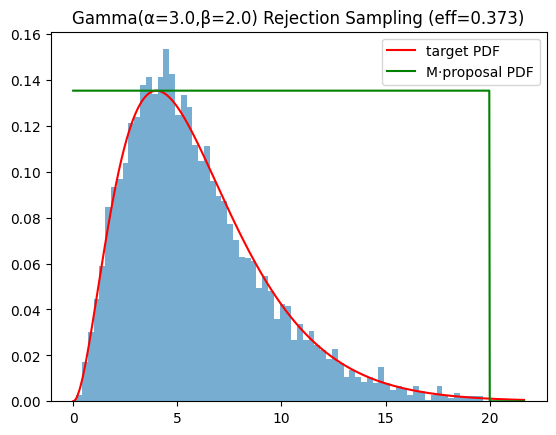

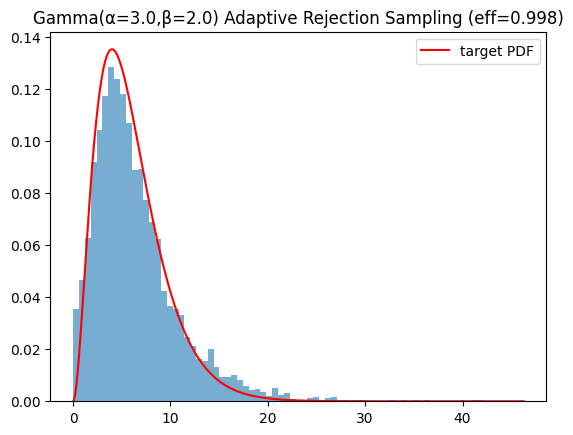

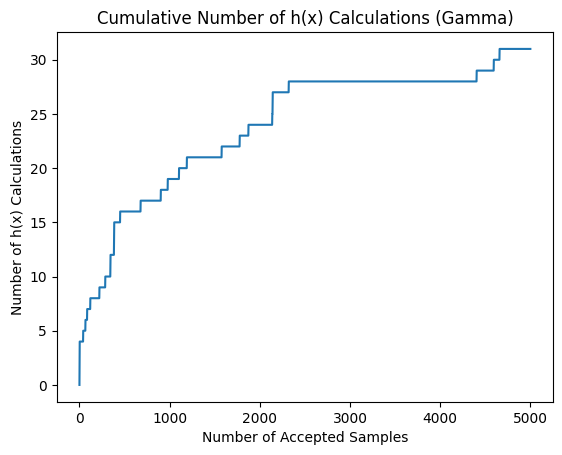

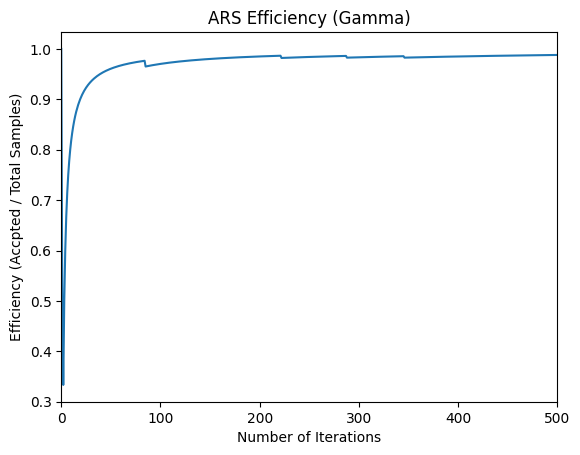

In [141]:
"""
Comparisons between traditional and adaptive rejection sampling using a Gamma(α, β) target distribution
"""

N = 5000

# ----- Gamma target parameters -----
alpha = 3.0
beta = 2.0
mode = (alpha - 1) * beta  # mode of Gamma(α,β)

# Target PDF for Gamma(α, β)
def gamma_pdf(x):
    # support x >= 0
    return np.where(
        x >= 0,
        x**(alpha - 1) * np.exp(-x / beta) / (special.gamma(alpha) * beta**alpha),
        0.0
    )

# ----- Traditional Rejection Sampling -----
rng = RNG()
proposal = Uniform(rng, low=0.0, high=20.0)

# Bounding constant: interval length * maximum of target_pdf on [0,20]
M = 20 * gamma_pdf(mode)

trad_samples, trad_efficiency = rejection_rsv(gamma_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Gamma(α={alpha},β={beta}) Rejection Sampling (eff={trad_efficiency:.3f})')

x = np.linspace(0, np.max(trad_samples)*1.1, 1000)
plt.plot(x, gamma_pdf(x), "red",   label="target PDF")
plt.plot(x,   M * proposal.pdf(x), "green", label="M·proposal PDF")
plt.legend()
plt.show()

# ----- Adaptive Rejection Sampling -----
log_pdf  = lambda x: (alpha - 1) * np.log(x) - x / beta \
                     - (math.log(special.gamma(alpha)) + alpha * np.log(beta))
dlog_pdf = lambda x: (alpha - 1) / x - 1 / beta

adap_samples, adap_efficiency, efficiency_array, calculations_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=0.0, Du=np.inf,
    initial_x=[mode / 2, mode * 2],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Gamma(α={alpha},β={beta}) Adaptive Rejection Sampling (eff={adap_efficiency:.3f})')

x = np.linspace(0, np.max(adap_samples)*1.1, 1000)
plt.plot(x, gamma_pdf(x), "red", label="target PDF")
plt.legend()
plt.show()

plt.plot(calculations_array)
plt.title("Cumulative Number of h(x) Calculations (Gamma)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

plt.plot(efficiency_array)
plt.title("ARS Efficiency (Gamma)")
plt.xlabel("Number of Iterations")
plt.ylabel("Efficiency (Accpted / Total Samples)")
plt.xlim(0, 500)
plt.show()


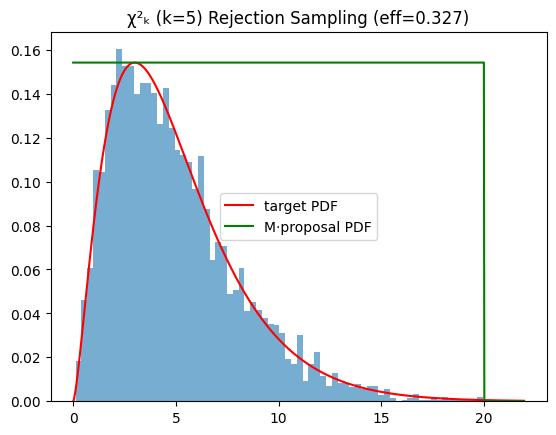

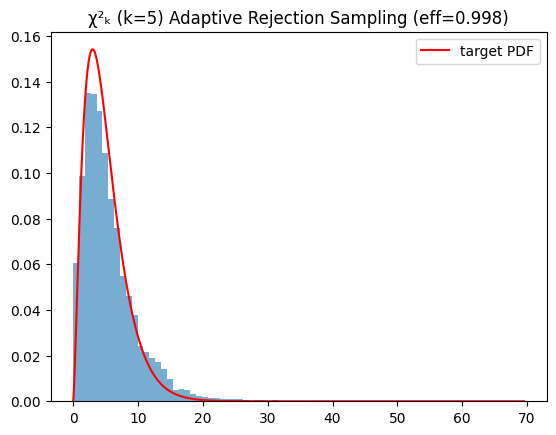

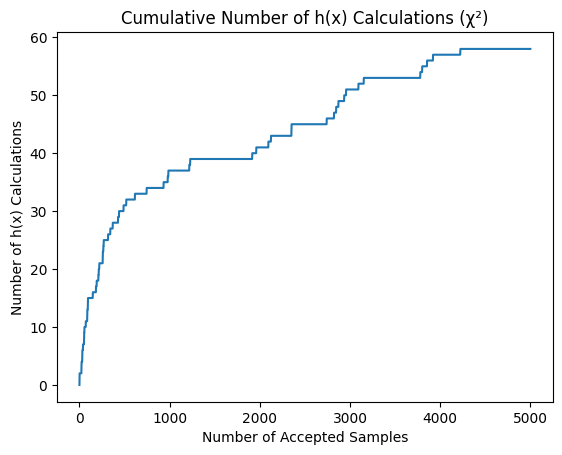

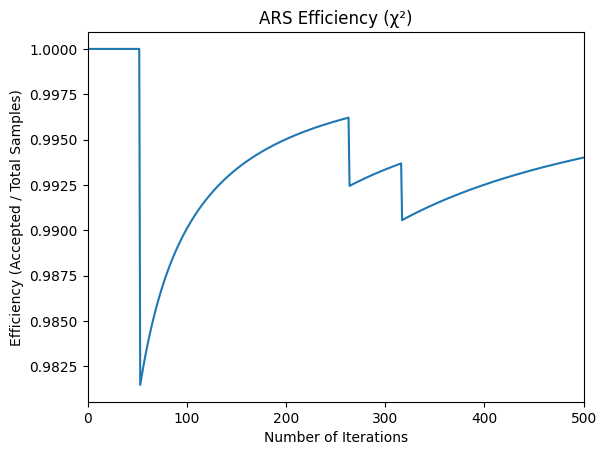

In [142]:
"""
Comparison for Chi‐Square(k) target distribution
"""
N = 5000

# ----- Chi-Square parameters -----
k = 5  # degrees of freedom (must be >2 for a mode)
mode = k - 2

# Target PDF for χ²ₖ
def chi2_pdf(x):
    return np.where(
        x >= 0,
        x**(k/2 - 1) * np.exp(-x/2) / (2**(k/2) * special.gamma(k/2)),
        0.0
    )

# ----- Traditional Rejection Sampling -----
rng = RNG()
proposal = Uniform(rng, low=0.0, high=20.0)

# Pick M = (length of [0,20]) * max target_pdf ≈ 20 * χ²ₖ(mode)
M = 20 * chi2_pdf(mode)

trad_samples, trad_efficiency = rejection_rsv(chi2_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'χ²ₖ (k={k}) Rejection Sampling (eff={trad_efficiency:.3f})')
x = np.linspace(0, np.max(trad_samples)*1.1, 1000)
plt.plot(x, chi2_pdf(x), 'red',   label='target PDF')
plt.plot(x, M*proposal.pdf(x), 'green', label='M·proposal PDF')
plt.legend()
plt.show()

# ----- Adaptive Rejection Sampling -----
log_pdf  = lambda x: ((k/2 - 1)*np.log(x) - x/2
                     - ((k/2)*np.log(2) + np.log(special.gamma(k/2))))
dlog_pdf = lambda x: (k/2 - 1)/x - 1/2

adap_samples, adap_efficiency, efficiency_array, calc_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=0.0, Du=np.inf,
    initial_x=[mode/2, mode*2],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'χ²ₖ (k={k}) Adaptive Rejection Sampling (eff={adap_efficiency:.3f})')
x = np.linspace(0, np.max(adap_samples)*1.1, 1000)
plt.plot(x, chi2_pdf(x), 'red', label='target PDF')
plt.legend()
plt.show()

plt.plot(calc_array)
plt.title("Cumulative Number of h(x) Calculations (χ²)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

plt.plot(efficiency_array)
plt.title("ARS Efficiency (χ²)")
plt.xlabel("Number of Iterations")
plt.ylabel("Efficiency (Accepted / Total Samples)")
plt.xlim(0, 500)
plt.show()


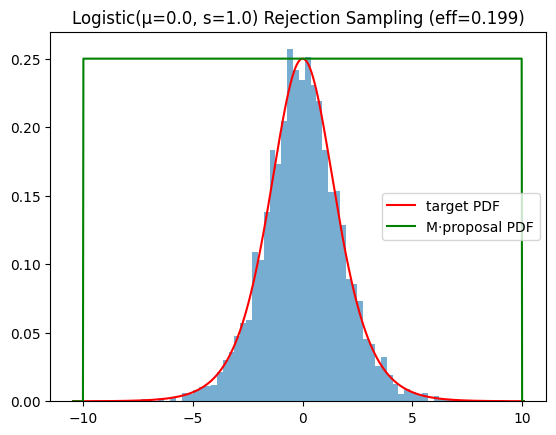

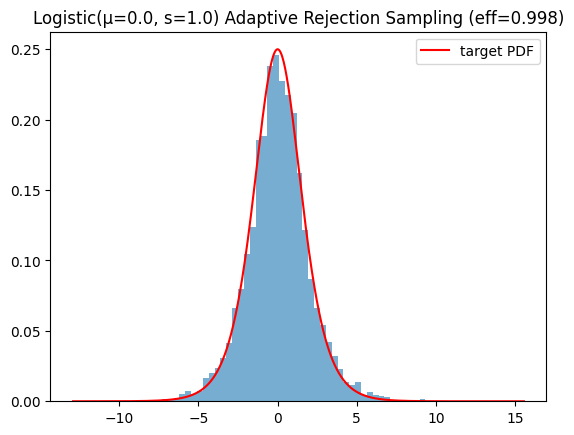

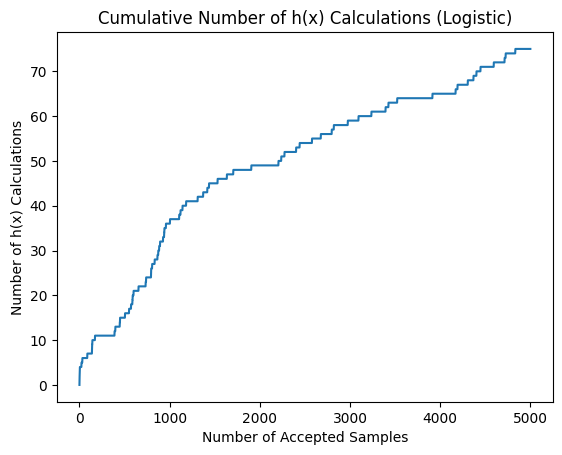

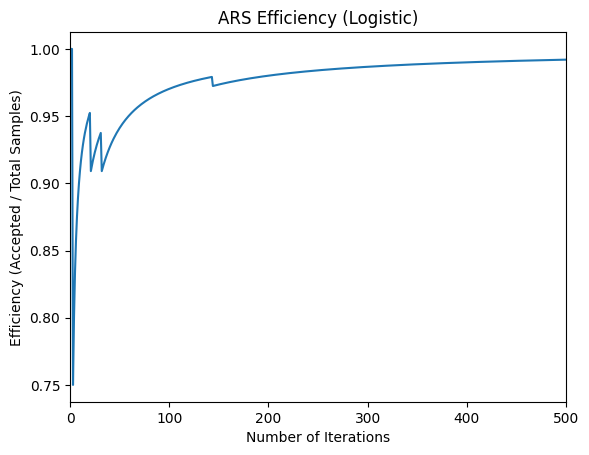

In [143]:
# Comparison for Logistic(μ, s) target distribution
import numpy as np
import math
import matplotlib.pyplot as plt

# ----- Logistic parameters -----
mu = 0.0
s  = 1.0
N  = 5000

# Target PDF for Logistic(μ, s)
def logistic_pdf(x):
    z = (x - mu) / s
    return np.exp(-z) / (s * (1 + np.exp(-z))**2)

# log‑pdf and its derivative
log_pdf  = lambda x: - (x - mu)/s - 2*np.log1p(np.exp(-(x - mu)/s)) - np.log(s)
dlog_pdf = lambda x: -1/s + 2/(s * (1 + np.exp((x - mu)/s)))

# ----- Traditional Rejection Sampling -----
rng      = RNG()
proposal = Uniform(rng, low=mu - 10*s, high=mu + 10*s)
# maximal target/pdf ratio: f(mu)=1/(4s), proposal.pdf=1/(20s) → M = (1/(4s)) / (1/(20s)) = 5
M = 5.0  

trad_samples, trad_efficiency = rejection_rsv(logistic_pdf, proposal, M, N)

plt.hist(trad_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Logistic(μ={mu}, s={s}) Rejection Sampling (eff={trad_efficiency:.3f})')
x = np.linspace(np.min(trad_samples)*1.1, np.max(trad_samples)*1.1, 1000)
plt.plot(x, logistic_pdf(x), 'red',   label='target PDF')
plt.plot(x,   M * proposal.pdf(x), 'green', label='M·proposal PDF')
plt.legend()
plt.show()


# ----- Adaptive Rejection Sampling -----
adap_samples, adap_efficiency, efficiency_array, calc_array = adaptive_rejection_sampling(
    log_pdf, dlog_pdf,
    Dl=-np.inf, Du=np.inf,
    initial_x=[mu - 2*s, mu + 2*s],
    n_samples=N
)

plt.hist(adap_samples, math.floor(math.sqrt(N)), density=True, alpha=0.6)
plt.title(f'Logistic(μ={mu}, s={s}) Adaptive Rejection Sampling (eff={adap_efficiency:.3f})')
x = np.linspace(np.min(adap_samples)*1.1, np.max(adap_samples)*1.1, 1000)
plt.plot(x, logistic_pdf(x), 'red', label='target PDF')
plt.legend()
plt.show()

plt.plot(calc_array)
plt.title("Cumulative Number of h(x) Calculations (Logistic)")
plt.xlabel("Number of Accepted Samples")
plt.ylabel("Number of h(x) Calculations")
plt.show()

plt.plot(efficiency_array)
plt.title("ARS Efficiency (Logistic)")
plt.xlabel("Number of Iterations")
plt.ylabel("Efficiency (Accepted / Total Samples)")
plt.xlim(0, 500)
plt.show()


## Discussion and Conclusions
Adaptive rejection sampling dramatically outperformed traditional rejection sampling by reducing the number of expensive log‐pdf evaluations, particularly for skewed distributions such as Gamma and χ². The cumulative count plots show a clear tapering of evaluations as the envelope and squeezing functions converge to the log-pdf, confirming the algorithm’s capability for self-tuning. Defining efficiency as the ratio of accepted samples to total samples yielded a performance metric consistently above 99% with a sample size of 5,000. Looking at the simulation results, we can see that the algorithm converges to this rate very quicky (usually within the first 500 samples). The rate of $h(x)$ recalculations also decreases as the hulls converge to the log-density and the algorithm optimizes itself. It was surprising how sensitive convergence was to the initial choice of abscissae. Poor starting points could slow adaptation, but simple heuristics (e.g. ensuring slopes cross zero) helped stabilize performance. Numerical edge cases, like nearly parallel tangents, required small tolerance thresholds to avoid division‐by-zero, but these were easy to incorporate into the coding implementation. Looking ahead, it would be worthwhile to investigate automatic abscissa selection, extensions to multivariate targets, or hybrid schemes that combine ARS with other MCMC methods to tackle more complex posteriors.

## References
Gilks, W. R., & Wild, P. (1992). Adaptive Rejection Sampling for Gibbs Sampling. Journal of the Royal Statistical Society. Series C (Applied Statistics), 41(2), 337–348. https://doi.org/10.2307/2347565

Hartmann, R., Meyer-Grant, C. G., & Klauer, K. C. (2023). An adaptive rejection sampler for sampling from the Wiener diffusion model. Behavior Research Methods, 55(5), 2283–2296. https://doi.org/10.3758/s13428-022-01870-z

Silva, A. R. S., Azevedo, C. L. N., Bazán, J. L., & Nobre, J. S. (2021). Bayesian inference for zero-and/or-one augmented beta rectangular regression models. Brazilian Journal of Probability and Statistics, 35(4), 749–771.